In [24]:
import torch


def attach_random_coreset_split(coresets, sub_train_loader, num_samples=200):
    """
    Attaches a randomly selected subset (coreset) from a given DataLoader to a list of coresets.
    
    This function selects a random subset from `sub_train_loader` based on `num_samples` and creates a new DataLoader for this subset.
    It then appends this new DataLoader to the provided list `coresets`. The original DataLoader (`sub_train_loader`) is modified
    by removing the selected subset indices, effectively partitioning the dataset.
    
    Args:
        coresets (list): A list where the new coreset DataLoader is appended.
        sub_train_loader (DataLoader): The DataLoader from which a random coreset is drawn.
        num_samples (int): The number of samples to include in the coreset.
    """
    
    # Extract current sample indices from the DataLoader
    task_indices = sub_train_loader.sampler.indices
    
    # Shuffle indices to ensure the randomness of the coreset
    shuffled_task_indices = task_indices[torch.randperm(len(task_indices))]
    
    # Select a subset of indices to form the coreset
    coreset_indices = shuffled_task_indices[:num_samples]
    
    # Update the DataLoader to exclude the coreset indices, thus reducing its size
    sub_train_loader.sampler.indices = shuffled_task_indices[num_samples:]
    
    # Create a new sampler for the coreset based on the selected indices
    coreset_sampler = torch.utils.data.SubsetRandomSampler(coreset_indices)
    
    # Create a new DataLoader for the coreset
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, 
        batch_size=sub_train_loader.batch_size, 
        sampler=coreset_sampler)
    
    # Append the new coreset DataLoader to the list of existing coresets
    coresets.append(coreset_loader)

def attach_kCenter_coreset_split(coresets, sub_train_loader, num_samples=200):
    dataset = sub_train_loader.dataset
    print(dataset[0].size())
    task_indices = sub_train_loader.sampler.indices
    loader_size = len(task_indices)

    #Initialization of first index
    distances = torch.full((loader_size,), float('inf'))
    #current_index = torch.randint(0, loader_size, (1,)).item()
    current_index = 0
    distances = _update_kcenter_distance(distances, dataset, task_indices, current_index)
    coreset_indices = [task_indices[current_index]]
    
    #Adding furthest indices one-by-one
    for _ in range(1, num_samples):
        current_index = distances.argmax().item()
        distances = _update_kcenter_distance(distances, dataset, task_indices, current_index)
        coreset_indices.append(task_indices[current_index])
    
    # Update the DataLoader to exclude the coreset indices, thus reducing its size
        # Update the DataLoader to exclude the coreset indices, thus reducing its size
    remaining_indices = list(set(task_indices) - set(coreset_indices))
    sub_train_loader.sampler.indices = remaining_indices

    # Create a new DataLoader for the coreset
    coreset_loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=sub_train_loader.batch_size, 
        sampler=torch.utils.data.SubsetRandomSampler(coreset_indices))
    
    # Append the new coreset DataLoader to the list of existing coresets
    coresets.append(coreset_loader)

def _update_kcenter_distance(distances, dataset, task_indices, current_index):
    #Re-calculate the distances based on the newest index addition
    for i, idx in enumerate(task_indices): #Warning! Our dataloader might not have function len
        current_dist = torch.norm(dataset[idx][0].float()-dataset[task_indices[current_index]][0].float(),p=2)
        distances[i] = torch.minimum(current_dist, distances[i])
    return distances


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# Step 1: Create a simple synthetic dataset
class SyntheticDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], 0  # Returning 0 as a dummy label

# Sample data: 10 points in 2D space
data = torch.tensor([[1.0, 2.0, 1.0], [2.0, 1.0,3.0], [2.0, 4.0,3.0], [4.0, 2.0,3.0],
                     [3.0, 3.0,3.0], [1.0, 3.0,3.0], [4.0, 1.0,3.0], [4.0, 4.0,3.0],
                     [3.0, 1.0,3.0], [1.0, 4.0,3.0]])

dataset = SyntheticDataset(data)

dataset_size = len(dataset)
indices = list(range(dataset_size))
sampler = SubsetRandomSampler(indices)

# Step 2: Prepare DataLoader
loader = DataLoader(dataset, batch_size=2, sampler=sampler)

# Step 3: Prepare a list to hold coresets (though it will hold only one for this test)
c = []

# Assuming attach_kCenter_coreset_split is correctly defined as per your requirement
attach_kCenter_coreset_split(c, loader, num_samples=5)

# Step 4: Verify the selected coreset
print("Coreset Indices:", c[0].sampler.indices)


NameError: name 'attach_kCenter_coreset_split' is not defined

In [6]:
loader.dataset[0][0]

tensor([1., 2., 1.])

#Plot choices

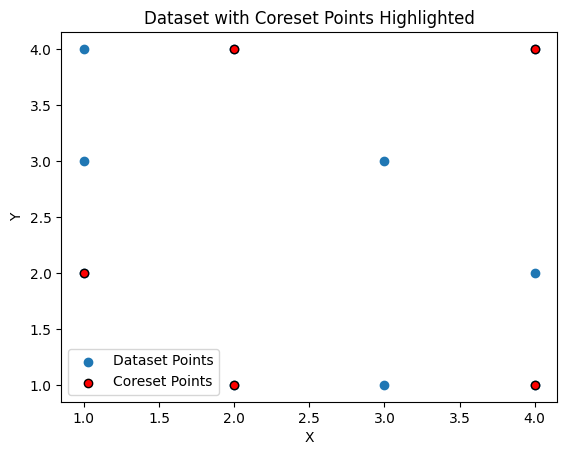

In [23]:
import matplotlib.pyplot as plt
import torch

def plot_dataset_with_coreset(data, coreset_indices):
    """
    Plot the dataset points and highlight the coreset points.

    Args:
        data (Tensor): The dataset, assumed to be a tensor of shape (n_points, 2).
        coreset_indices (list or Tensor): Indices of the coreset points.
    """
    # Convert coreset_indices to a list if it's a Tensor
    if isinstance(coreset_indices, torch.Tensor):
        coreset_indices = coreset_indices.tolist()

    # Extract x and y coordinates of all points
    x_all = data[:, 0].numpy()
    y_all = data[:, 1].numpy()

    # Extract x and y coordinates of coreset points
    x_coreset = data[coreset_indices, 0].numpy()
    y_coreset = data[coreset_indices, 1].numpy()

    # Plot all points
    plt.scatter(x_all, y_all, label='Dataset Points')

    # Highlight coreset points
    plt.scatter(x_coreset, y_coreset, color='red', label='Coreset Points', edgecolor='black')

    # Adding title and legend
    plt.title('Dataset with Coreset Points Highlighted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

    # Show plot
    plt.show()

# Example usage based on your dataset and chosen coreset indices
data = torch.tensor([[1.0, 2.0], [2.0, 1.0], [2.0, 4.0], [4.0, 2.0],
                     [3.0, 3.0], [1.0, 3.0], [4.0, 1.0], [4.0, 4.0],
                     [3.0, 1.0], [1.0, 4.0]])

coreset_indices = [0, 7, 6, 2, 1]

plot_dataset_with_coreset(data, coreset_indices)


# Code from the original paper (OR)

In [18]:
# K-center coreset selection
# def OR_k_center(x_coreset, y_coreset, x_train, y_train, coreset_size):
def OR_k_center(x_train, coreset_size):
    # Select K centers from (x_train, y_train) and add to current coreset (x_coreset, y_coreset)
    dists = torch.full((x_train.size(0),), float('inf'))
    current_id = 0
    dists = OR_update_distance(dists, x_train, current_id)
    idx = [current_id]

    for i in range(1, coreset_size):
        current_id = dists.argmax()
        dists = OR_update_distance(dists, x_train, current_id)
        idx.append(current_id)
    
    print(idx)

    # x_coreset.append(x_train[idx])
    # y_coreset.append(y_train[idx])
    # x_train = torch.cat([x_train[:idx.min()], x_train[idx.max() + 1:]], dim=0)
    # y_train = torch.cat([y_train[:idx.min()], y_train[idx.max() + 1:]], dim=0)

    # return x_coreset, y_coreset, x_train, y_train

def OR_update_distance(dists, x_train, current_id):
    for i in range(x_train.size(0)):
        current_dist = torch.norm(x_train[i] - x_train[current_id])
        dists[i] = torch.minimum(current_dist, dists[i])
    return dists

Test their code:

In [19]:
OR_k_center(data, 5)

[0, tensor(7), tensor(6), tensor(2), tensor(1)]
